## Uso de dados para otimizar a alocação de recursos públicos destinados ao saneamento básico de Goiás

### ADENILSON SILVA

Para controle do fluxo de atividades do projeto, a consultoria utilizou o trello. O painel criado está disponível em:

# CARREGAMENTO DOS DADOS

Para uma gestão mais eficiente das informações, a Secretaria de Meio Ambiente do Estado de Goiás solicitou que os dados tratados não fossem disponibilizados em arquivos .csv. Em vez disso, foi requisitado que fossem inseridos em um banco de dados. Diante dessa exigência, a empresa de consultoria optou por utilizar o _PostgreSQL_ para essa finalidade. 

#### Modelo Entidade Relacionamento - MER

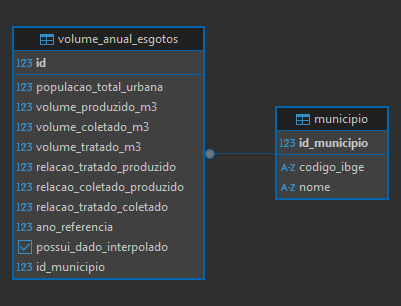

#### _Script_ de criação do banco

```sql
create database gestao_esgotos_goiais;

create table municipio (
	id_municipio SERIAL primary key,
    codigo_ibge VARCHAR(50) not null,
	nome VARCHAR(255) not null
);

comment on
table municipio is 'Tabela que armazena informações sobre os municípios.';

comment on
column municipio.id_municipio is 'Identificador único do município.';

comment on
column municipio.codigo_ibge is 'Código IBGE único para cada município.';

comment on
column municipio.nome is 'Nome oficial do município.';

create table municipio (
	id_municipio SERIAL primary key,
    codigo_ibge VARCHAR(50) not null,
	nome VARCHAR(255) not null
);

comment on
table municipio is 'Tabela que armazena informações sobre os municípios.';

comment on
column municipio.id_municipio is 'Identificador único do município.';

comment on
column municipio.codigo_ibge is 'Código IBGE único para cada município.';

comment on
column municipio.nome is 'Nome oficial do município.';


create table volume_anual_esgotos (
	id SERIAL primary key,
	populacao_total_urbana INTEGER not null,
	volume_produzido_m3 real not null,
    volume_coletado_m3 real not null,
    volume_tratado_m3 real not null,
    relacao_tratado_produzido numeric(10, 2) generated always as (
    coalesce(volume_tratado_m3 / nullif(volume_produzido_m3, 0), 0)
	) stored,
	relacao_coletado_produzido numeric(10, 2) generated always as (
    coalesce(volume_coletado_m3 / nullif(volume_produzido_m3, 0), 0)
	) stored,
	relacao_tratado_coletado numeric(10, 2) generated always as (
    coalesce(volume_tratado_m3 / nullif(volume_coletado_m3, 0), 0)
	) stored,
    ano_referencia INTEGER not null,
	possui_dado_interpolado bool not null default false, 
    id_municipio INTEGER not null references municipio(id_municipio)
);

comment on
table volume_anual_esgotos is 'Tabela que armazena os volumes anuais de esgoto dos municípios.';

comment on
column volume_anual_esgotos.id is 'Identificador único da entrada de volume de esgoto.';

comment on
column volume_anual_esgotos.populacao_total_urbana is 'Número total de habitantes em áreas urbanas.';

comment on
column volume_anual_esgotos.volume_produzido_m3 is 'Quantidade de esgoto produzido em metros cúbicos.';

comment on
column volume_anual_esgotos.volume_coletado_m3 is 'Quantidade de esgoto coletado em metros cúbicos.';

comment on
column volume_anual_esgotos.volume_tratado_m3 is 'Quantidade de esgoto tratado em metros cúbicos.';

comment on
column volume_anual_esgotos.relacao_tratado_produzido is 'Relação entre volume tratado e produzido (tratado/produzido).';

comment on
column volume_anual_esgotos.relacao_coletado_produzido is 'Relação entre volume coletado e produzido (coletado/produzido).';

comment on
column volume_anual_esgotos.relacao_tratado_coletado is 'Relação entre volume tratado e coletado (tratado/coletado).';

comment on
column volume_anual_esgotos.ano_referencia is 'Ano de Referência do registro.';

comment on
column volume_anual_esgotos.id_municipio is 'Identificador do município ao qual o volume de esgoto pertence.';
```

A seguir, é apresentado o código utilizado pela consultoria para o carregamento dos dados do projeto.

####  1 - Importando bibliotecas

In [18]:
import pandas as pd  # Usada para trabalhar com dados em formato de tabela (DataFrame)
import os  # Usada para lidar com operações do sistema de arquivos
from sqlalchemy import create_engine  # Usada para criar e gerenciar conexões com bancos de dados

#### 2 - Definindo as credenciais do banco _PosgreSQL_

In [19]:
user_postgres = 'postgres' # usuário 
password_postgres = 'postgres' # senha
host_postgres = 'localhost'# hot
port_postgres = '5432' # porta
dbname_postgres = 'gestao_esgotos_goiais' # nome do banco

# Cria uma engine do SQLAlchemy para conectar-se a um banco de dados PostgreSQL
engine = create_engine(f'postgresql://{user_postgres}:{password_postgres}@{host_postgres}:{port_postgres}/{dbname_postgres}')

#### 3 -  Obtendo os dados tratados

In [20]:
# Gerando o Dataframe com a série histórica da coleta e tratamento de esgotos dos municipios de Goiás
df_volume_anual_esgotos = pd.read_csv('dados_GO/B - dado_tratado/df_municipios_habitantes_saneamento_codigo.csv', 
                delimiter = ';',
                encoding = 'utf-8',
                index_col= False)

# Visualizando os primeiros 5 registros do Dataframe
df_volume_anual_esgotos.head()

,Código do Município (IBGE),Município,Ano,População Total Urbana,Volume de esgoto produzido - 1000 m³,Volume de esgotos coletado - 1000 m³,Volume de esgotos tratado - 1000 m³,Possui dado interpolado?
0,5200050,Abadia de Goiás,1992,0,0.00,0.0,0.0,Não
1,5200100,Abadiânia,1992,8526,404.56,0.0,0.0,Não
2,5200134,Acreúna,1992,13111,622.12,0.0,0.0,Não
3,5200159,Adelândia,1992,2110,100.12,0.0,0.0,Não
4,5200175,Água Fria de Goiás,1992,3601,170.87,0.0,0.0,Não


#### Definindo os dados que serão inseridos na tabela "municipio"

In [21]:
df_municipios = df_volume_anual_esgotos[['Código do Município (IBGE)', 'Município']].drop_duplicates()
renome_colunas = {
    'Código do Município (IBGE)': 'codigo_ibge',
    'Município': 'nome',
}
# Renomeando as colunas
df_municipios = df_municipios.rename(columns=renome_colunas)
df_municipios.head() 

,codigo_ibge,nome
0,5200050,Abadia de Goiás
1,5200100,Abadiânia
2,5200134,Acreúna
3,5200159,Adelândia
4,5200175,Água Fria de Goiás


In [23]:
with engine.begin() as conn:
    conn.execute("delete from volume_anual_esgotos")   # Remove os dados antes de inserir os novos registros
    conn.execute("delete from municipio")

# Inserindo os dados no banco
df_municipios.to_sql("municipio", engine, if_exists="append", index=False)

print("Dados inseridos com sucesso!")

Dados inseridos com sucesso!


In [24]:
# Consultando a tabela "municipios" para obter os ids
query = "select * from municipio;"

df_municipio_consulta = pd.read_sql(query, engine)
df_municipio_consulta['codigo_ibge'] = df_municipio_consulta['codigo_ibge'].astype('int64')
df_municipio_consulta.head()

,id_municipio,codigo_ibge,nome
0,985,5200050,Abadia de Goiás
1,986,5200100,Abadiânia
2,987,5200134,Acreúna
3,988,5200159,Adelândia
4,989,5200175,Água Fria de Goiás


In [25]:
# Unindo os dataframes para posterior inserção dos dados na tabela "volume_anual_esgotos" 
colunas_excluidas = ['codigo_ibge','Código do Município (IBGE)', 'Município', 'nome']
df_juncao_municipios_volume_anual_esgotos = pd.merge(df_municipio_consulta, 
                                                      df_volume_anual_esgotos, 
                                                      left_on=['codigo_ibge'], 
                                                      right_on=['Código do Município (IBGE)'], 
                                                      how='inner').drop(columns=colunas_excluidas)
df_juncao_municipios_volume_anual_esgotos.head()

,id_municipio,Ano,População Total Urbana,Volume de esgoto produzido - 1000 m³,Volume de esgotos coletado - 1000 m³,Volume de esgotos tratado - 1000 m³,Possui dado interpolado?
0,985,1992,0,0.00,0.0,0.0,Não
1,985,1993,0,0.00,0.0,0.0,Não
2,985,1994,0,0.00,0.0,0.0,Não
3,985,1995,0,0.00,0.0,0.0,Não
4,985,1997,3121,148.09,0.0,0.0,Não


#### Definindo os dados que serão inseridos na tabela "volume_anual_esgotos"

In [26]:
renome_colunas = {
    'Ano': 'ano_referencia',
    'População Total Urbana': 'populacao_total_urbana',
    'Volume de esgoto produzido - 1000 m³': 'volume_produzido_m3',
    'Volume de esgotos coletado - 1000 m³': 'volume_coletado_m3',
    'Volume de esgotos tratado - 1000 m³': 'volume_tratado_m3',
    'Possui dado interpolado?': 'possui_dado_interpolado',
}

# Renomeando as colunas
df_juncao_municipios_volume_anual_esgotos = df_juncao_municipios_volume_anual_esgotos.rename(columns=renome_colunas)

df_juncao_municipios_volume_anual_esgotos['possui_dado_interpolado'] = df_juncao_municipios_volume_anual_esgotos['possui_dado_interpolado'].map({'Sim': True, 'Não': False})

df_juncao_municipios_volume_anual_esgotos.head()

,id_municipio,ano_referencia,populacao_total_urbana,volume_produzido_m3,volume_coletado_m3,volume_tratado_m3,possui_dado_interpolado
0,985,1992,0,0.00,0.0,0.0,False
1,985,1993,0,0.00,0.0,0.0,False
2,985,1994,0,0.00,0.0,0.0,False
3,985,1995,0,0.00,0.0,0.0,False
4,985,1997,3121,148.09,0.0,0.0,False


In [27]:
with engine.begin() as conn:
    conn.execute("delete from volume_anual_esgotos")  # Remove os dados antes de inserir os novos registros

# Inserindo os dados no banco
df_juncao_municipios_volume_anual_esgotos.to_sql("volume_anual_esgotos", engine, if_exists="append", index=False)

print("Dados inseridos com sucesso!")

Dados inseridos com sucesso!


### Dados sobre versão
- Python: 3.11.4
- pandas==1.3.4
- psycopg2==1.4.22